In [2]:
import torch
import random
import torchvision
import numpy as np
from PIL import Image
from dataclasses import dataclass
from __future__ import annotations
from matplotlib import pyplot as plt

@dataclass
class Curve:
    p: int
    a: int
    b: int

@dataclass
class Point:
    curve: Curve
    x: int
    y: int

@dataclass
class Generator:
    G: Point
    n: int 

bitcoin_curve = Curve(
    p = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFC2F,
    a = 0x0000000000000000000000000000000000000000000000000000000000000000,
    b = 0x0000000000000000000000000000000000000000000000000000000000000007,
)

G = Point(
    bitcoin_curve,
    x = 0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798,
    y = 0x483ada7726a3c4655da4fbfc0e1108a8fd17b448a68554199c47d08ffb10d4b8,
)

bitcoin_gen = Generator(
    G = G,
    n = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141,
)

INF = Point(None, None, None) 

def extended_euclidean_algorithm(a, b):
    old_r, r = a, b
    old_s, s = 1, 0
    old_t, t = 0, 1
    while r != 0:
        quotient = old_r // r
        old_r, r = r, old_r - quotient * r
        old_s, s = s, old_s - quotient * s
        old_t, t = t, old_t - quotient * t
    return old_r, old_s, old_t

def inv(n, p):
    gcd, x, y = extended_euclidean_algorithm(n, p)
    return x % p

def elliptic_curve_addition(self, other: Point) -> Point:
    if self == INF:
        return other
    if other == INF:
        return self
    if self.x == other.x and self.y != other.y:
        return INF
    if self.x == other.x:
        m = ((3 * self.x**2 + self.curve.a) * inv(2 * self.y, self.curve.p)) % self.curve.p
    else:
        m = ((self.y - other.y) * inv((self.x - other.x) % self.curve.p, self.curve.p)) % self.curve.p
    rx = (m**2 - self.x - other.x) % self.curve.p
    ry = ((m*(self.x - rx) - self.y)) % self.curve.p
    return Point(self.curve, rx, ry)

Point.__add__ = elliptic_curve_addition

def double_and_add(self, k: int) -> Point:
    assert isinstance(k, int) and k >= 0
    result = INF
    append = self
    while k:
        if k & 1:
            result += append
        append += append
        k >>= 1
    return result

Point.__rmul__ = double_and_add

def elliptic_curve_subtraction(self, other: Point) -> Point:
    inverse_other = Point(self.curve, other.x, (self.curve.p - other.y) % self.curve.p)
    return self + inverse_other

Point.__sub__ = elliptic_curve_subtraction

secret_key = 3

def get_bin(x, n=0):
    return format(x, "b").zfill(n)

def extract_channels(filepath):
    img = Image.open(filepath)
    img = torchvision.transforms.ToTensor()(img) * 255
    img = img.to(torch.uint8)
    channel_pixels = []
    for channel in range(img.ndim):
        channel_pixels.append(img[channel].flatten())
    return channel_pixels, img.shape[1]

def group_pixels(channel_pixel):
    batch = []
    group = ""
    for pixel in channel_pixel:
        group += get_bin(pixel, 8)
        if len(group) == 256:
            batch.append(group)
            group = ""
    return batch

def make_points_and_encrypt(grouped_pixels, random_key, public_key):
    points = []
    for i in range(0, len(grouped_pixels)-1, 2):
        message_point = Point(bitcoin_curve, int(grouped_pixels[i], 2), int(grouped_pixels[i+1], 2)) 
        c2_point = message_point + (random_key * public_key)  # c2 = m + r.P
        points.append(c2_point)
    return points

def get_channel_for_cipher_image(points, width):
    pixel_values = []
    for point in points:
        x, y = point.x, point.y
        bins = get_bin(x, 256)
        nums_x = [int(bins[i:i+8], 2) for i in range(0, len(bins), 8)]
        pixel_values.append(nums_x)
        bins = get_bin(y, 256)
        nums_y = [int(bins[i:i+8], 2) for i in range(0, len(bins), 8)]
        pixel_values.append(nums_y)
    pixel_values = torch.tensor(pixel_values).flatten().reshape(width, -1)
    return pixel_values

def encrypt_image(filepath):
    public_key = secret_key * G                        # public key (p = k.G)
    random_key = random.randint(1, bitcoin_gen.n-1)    # random_key (r)
    c1 = random_key * G                                # cipher_text_1 (c1 = r * G)
    
    secret_channels = []
    channel_pixels, width = extract_channels(filepath)
    for channel_pixel in channel_pixels:
        grouped_pixels = group_pixels(channel_pixel)  
        c2_channel_points = make_points_and_encrypt(grouped_pixels, random_key, public_key)
        sec_channel = get_channel_for_cipher_image(c2_channel_points, width) 
        secret_channels.append(sec_channel)
    encrypted_image = np.dstack((tuple(secret_channels)))
    return c1, encrypted_image

def make_points_and_decrypt(c1_point, c2_points_list, private_key):
    decrypted_points = []
    for c2_point in c2_points_list:
        decrypted_point = c2_point - (private_key * c1_point) # m = c2 - (k.c1)
        decrypted_points.append(decrypted_point)
    return decrypted_points

def get_points_from_cipher_image(img, width):
    pixels_flat = img.flatten()
    grouped_pixels = []
    current_group = ""
    for pixel in pixels_flat:
        current_group += get_bin(pixel, 8)
        if len(current_group) == 256:
            grouped_pixels.append(current_group)
            current_group = ""
    
    points = []
    for i in range(0, len(grouped_pixels) - 1, 2):
        x = int(grouped_pixels[i], 2)
        y = int(grouped_pixels[i+1], 2)
        points.append(Point(bitcoin_curve, x, y))
    return points


def decrypt_image(c1, filepath):
    private_key = secret_key
    encrypted_channels, width = extract_channels(filepath)
    
    original_channels = []
    for encrypted_channel in encrypted_channels:
        c2_points_list = get_points_from_cipher_image(encrypted_channel, width)
        original_points = make_points_and_decrypt(c1, c2_points_list, private_key)        
        decrypted_channel_pixels = get_channel_for_cipher_image(original_points, width)
        original_channels.append(decrypted_channel_pixels)  
    return np.dstack((tuple(original_channels)))

In [3]:
c1, c2 = encrypt_image("images/bird.jpg")
c1, c2.shape

(Point(curve=Curve(p=115792089237316195423570985008687907853269984665640564039457584007908834671663, a=0, b=7), x=23670408129235084494380335408467572898854851830000591767173981580804781817841, y=85772062835196604942378913399477930131399349716369172893573735517129399835124),
 (128, 128, 3))

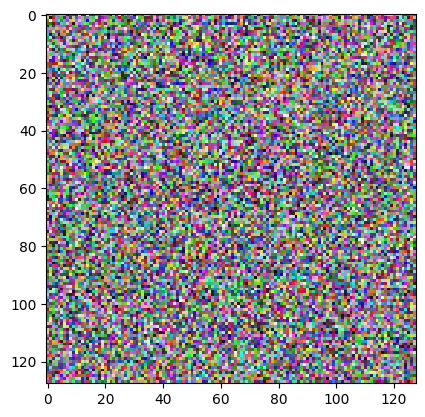

In [4]:
plt.imshow(c2, interpolation="nearest")
plt.show()
im = Image.fromarray((c2).astype(np.uint8))
im.save("./images/enc.png")

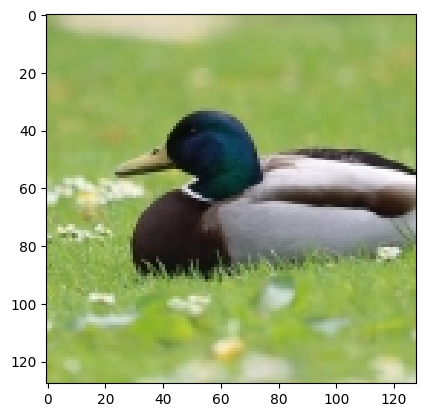

In [5]:
dec_img = decrypt_image(c1, "images/enc.png")
plt.imshow(dec_img, interpolation="nearest")
plt.show()
im = Image.fromarray((dec_img).astype(np.uint8))
im.save("./images/dec.png")